# Глубокие Нейронные сети

## Библиотеки

In [6]:
# !pip install lime

In [4]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
from urllib.request import urlopen
from lime import lime_image
from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
import torch

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms


/Users/ian/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ian/miniconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <88D9A18E-C231-3902-930D-BF8F4ABC8224> /Users/ian/miniconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/ian/miniconda3/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
import warnings
warnings.filterwarnings("ignore")

## Зададим устройство исполнения кода (cpu/cuda)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Сверточная нейронная сеть

### Полезный код для обучения модели

In [8]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()
    
    output = model(x_batch.to(device))
    
    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [9]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), 
                                    optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total
        

In [10]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size + (len(dataset)%batch_size > 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

### Модель нейросети

In [19]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(1, 1*6, kernel_size = 5))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2))
        
        self.layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size = 5))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2))
        
        # этот слой растягивает матрицу в вектор, flattens it
        self.layers.add_module('flatten', torch.nn.Flatten())
        
        # обычные полносвязные слои
        self.layers.add_module('linear1', torch.nn.Linear(16*4*4, 120))
        self.layers.add_module('relu3', torch.nn.ReLU())
        
        self.layers.add_module('linear2', torch.nn.Linear(120, 84))
        self.layers.add_module('relu4', torch.nn.ReLU())
        
        self.layers.add_module('linear3', torch.nn.Linear(84, 10))

    def forward(self, input):
        return self.layers(input)

### Выборка

In [12]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



### Инициализация модели

In [20]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=256, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Качество аппроксимации до обучения

In [21]:
batch_generator = torch.utils.data.DataLoader(dataset = MNIST_test, 
                                              batch_size=64)
            
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    output = model(x_batch)

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(MNIST_test)

print('loss: {}'.format(test_loss))

loss: 2.3052956680297854


### Визуализация каждого слоя сверточной нейросети

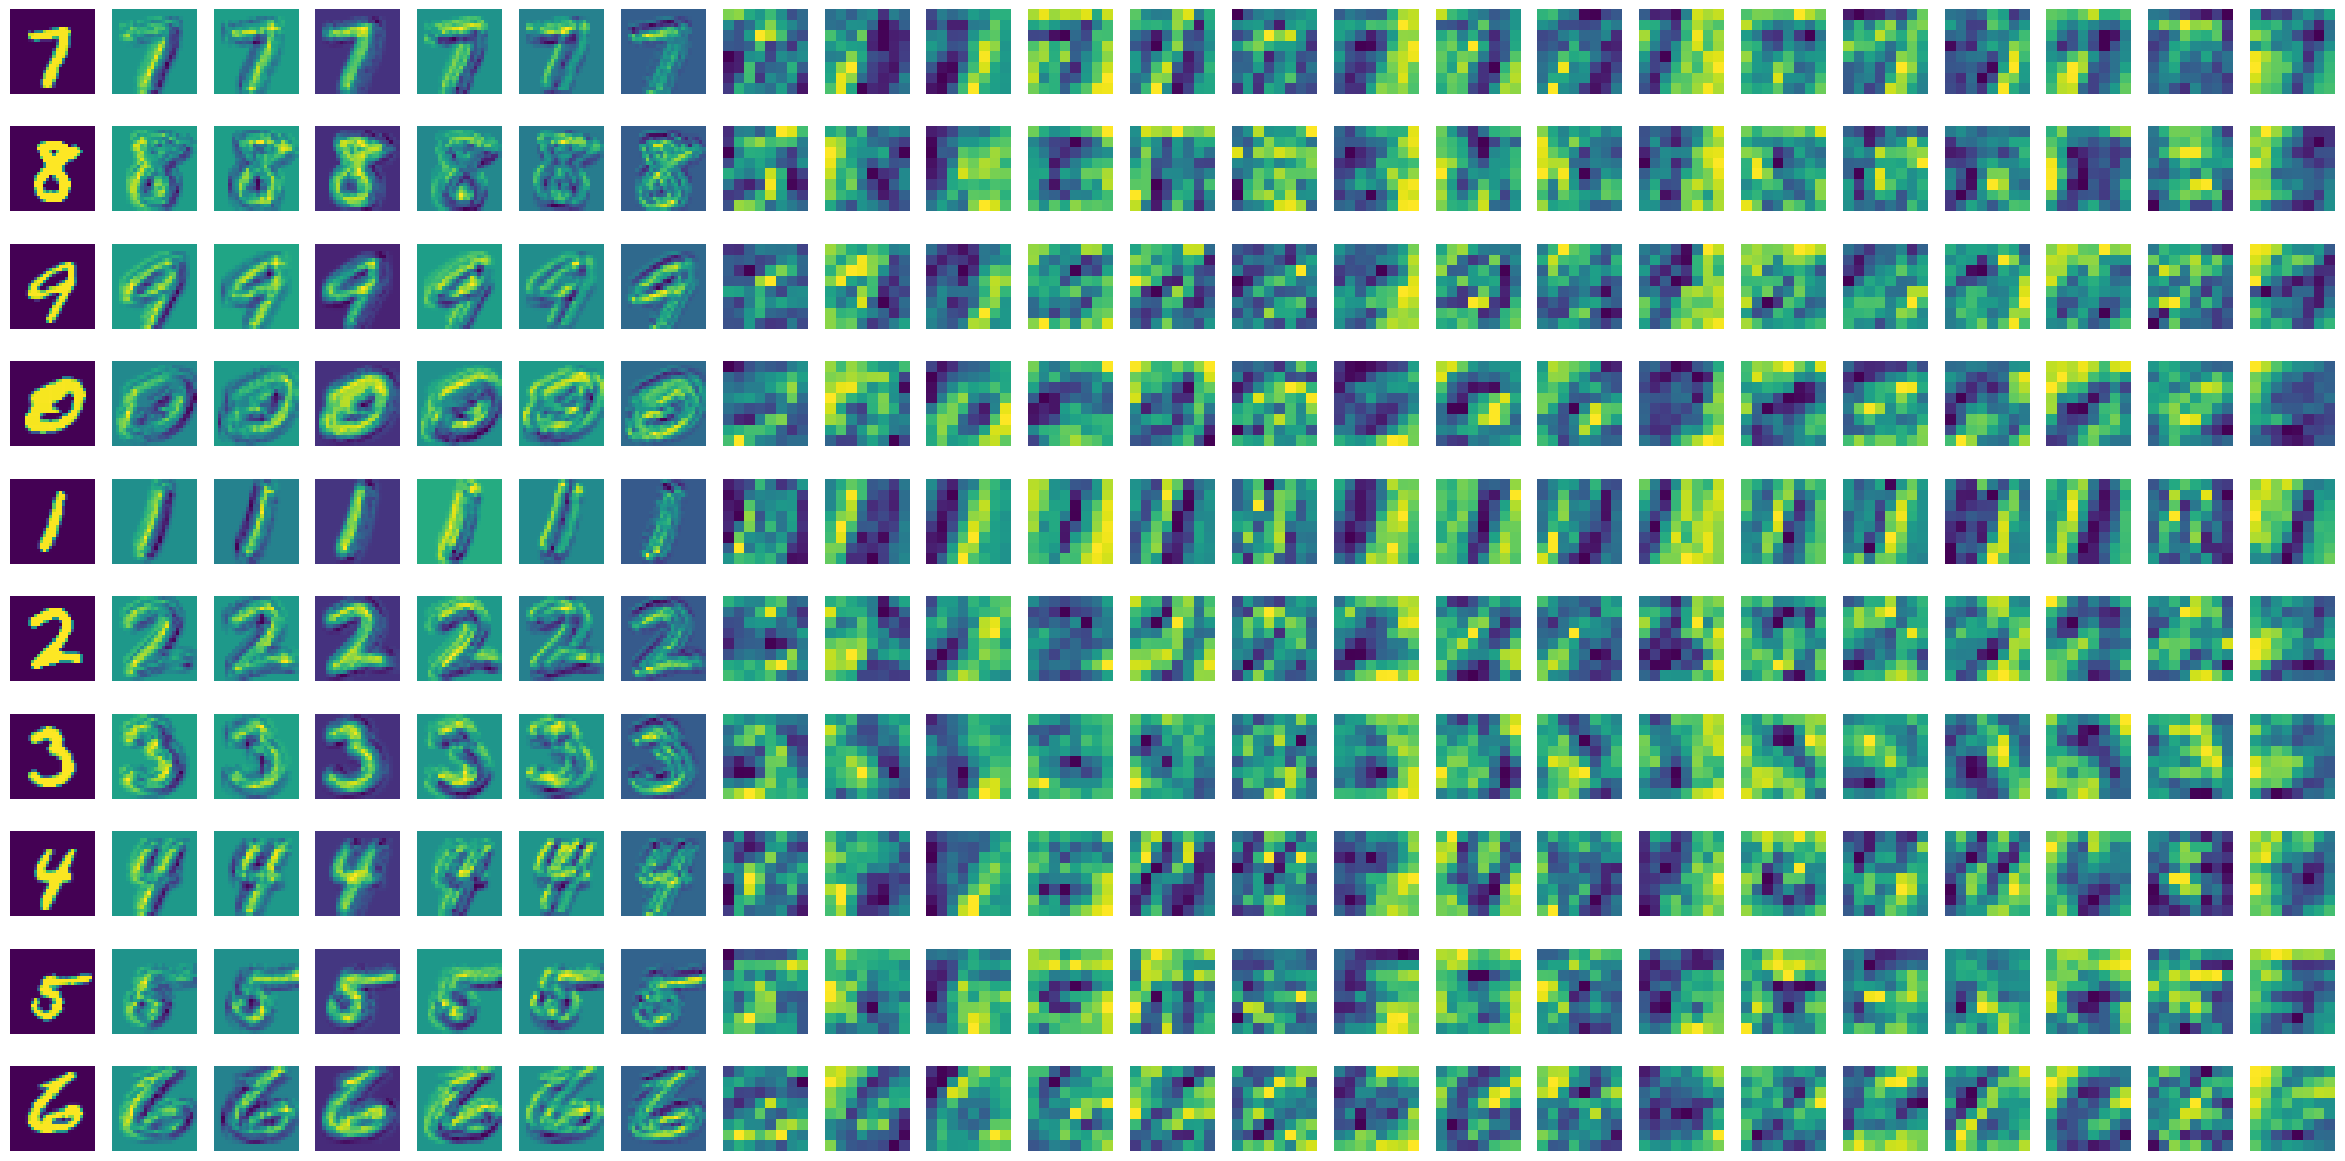

In [15]:
x = x_batch[-10:]
y = model.layers.conv1(x)
z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

fig = plt.figure(figsize=(30, 15))
gs = gridspec.GridSpec(10, 23)
ax = np.empty([10, 23], dtype=object)
for i in range(10):
    for j in range(23):
        ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(len(x)):
    ax[i][0].imshow(x.cpu().data[i, 0].numpy())
    ax[i][0].axis("off")
    for j in range(1, 7):
        ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
        ax[i][j].axis("off")

    for j in range(7, 23):
        ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
        ax[i][j].axis("off")

### Обучение модели

In [22]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = MNIST_train,
        model = model, # Качество аппроксимации до обучения
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = None)

epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

### Качество аппроксимации после обучения

In [23]:
batch_generator = torch.utils.data.DataLoader(dataset = MNIST_test, 
                                              batch_size=64)
            
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    output = model(x_batch)

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(MNIST_test)

print('loss: {}'.format(test_loss))

loss: 0.09065490967035293


### Визуализация каждого слоя сверточной нейросети

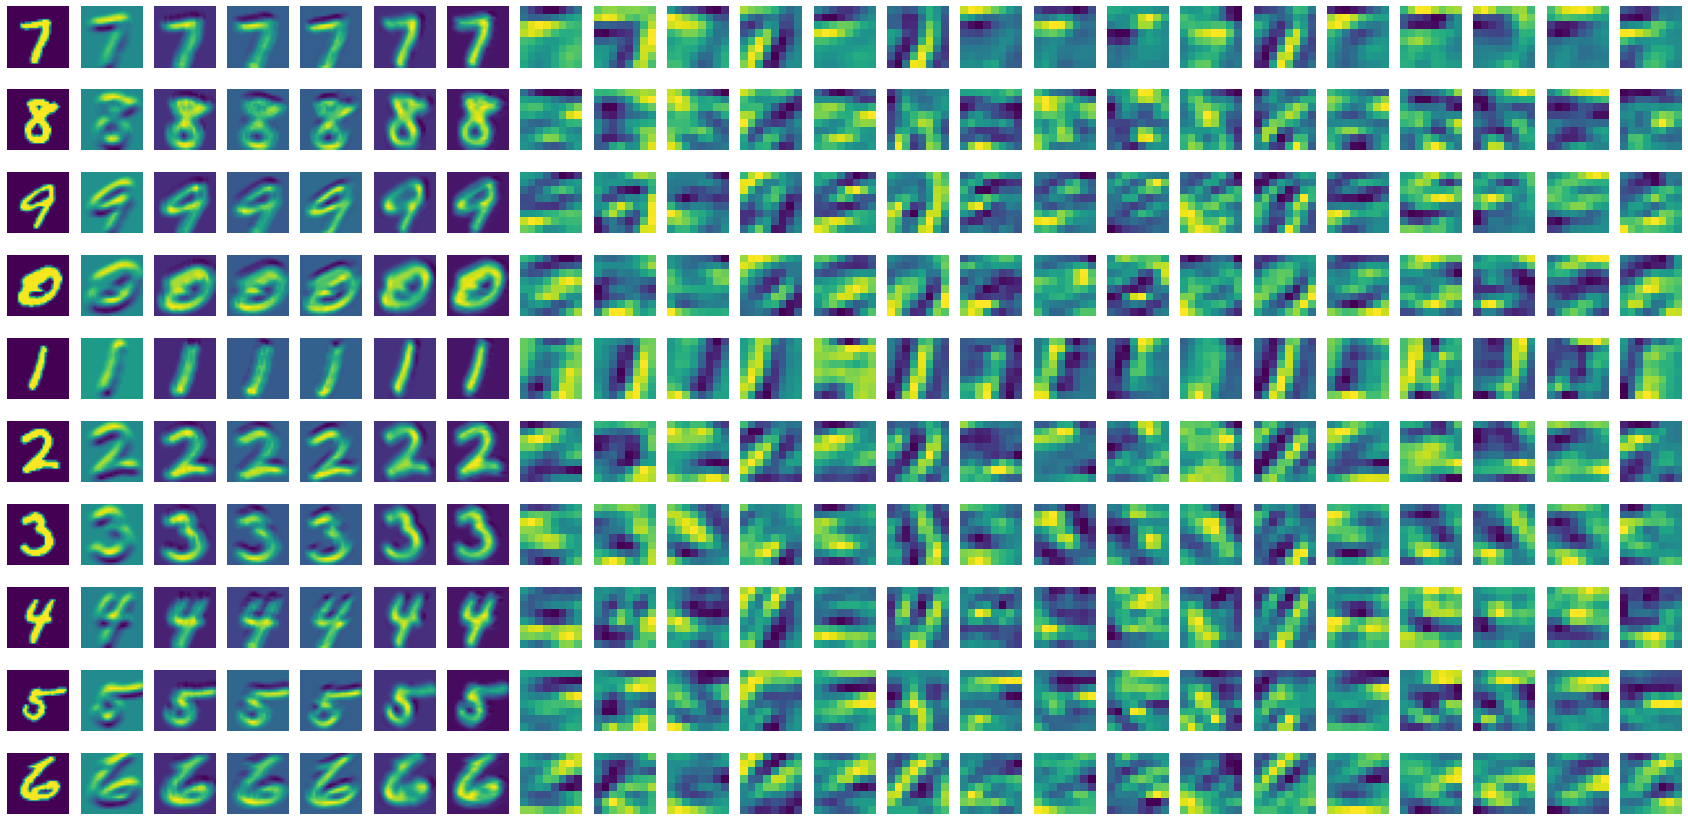

In [ ]:
x = x_batch[-10:]
y = model.layers.conv1(x)
z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

fig = plt.figure(figsize=(30, 15))
gs = gridspec.GridSpec(10, 23)
ax = np.empty([10, 23], dtype=object)
for i in range(10):
    for j in range(23):
        ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(len(x)):
    ax[i][0].imshow(x.cpu().data[i, 0].numpy())
    ax[i][0].axis("off")
    for j in range(1, 7):
        ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
        ax[i][j].axis("off")

    for j in range(7, 23):
        ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
        ax[i][j].axis("off")

## Отслеживание обучения модели

In [24]:
%load_ext tensorboard
%tensorboard --logdir experiment/

In [25]:
class callback():
    """Вспомогательный класс для отслеживания обучения модели"""
    
    def __init__(self, writer, dataset, loss_function, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            self.writer.add_graph(model, self.dataset[0][0].view(1, 1, 28, 28).to(model.device))
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size)
            
            pred = []
            real = []
            test_loss = 0
            for it, (x_batch, y_batch) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)
                y_batch = y_batch.to(model.device)

                output = model(x_batch)

                test_loss += self.loss_function(output, y_batch).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
                real.extend(y_batch.cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
            self.writer.add_text('REPORT/test', str(classification_report(real, pred)), self.step)

            x = x_batch[-10:]
            y = model.layers.conv1(x.to(model.device))
            z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

            fig = plt.figure(figsize=(30, 15))
            gs = gridspec.GridSpec(10, 23)
            ax = np.empty([10, 23], dtype=object)
            for i in range(10):
                for j in range(23):
                    ax[i][j] = fig.add_subplot(gs[i, j])
            for i in range(len(x)):
                ax[i][0].imshow(x.cpu().data[i, 0].numpy())
                ax[i][0].axis("off")
                for j in range(1, 7):
                    ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
                    ax[i][j].axis("off")

                for j in range(7, 23):
                    ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
                    ax[i][j].axis("off")
            self.writer.add_figure('CNN/convs', fig, self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [26]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=256, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [27]:
writer = SummaryWriter(log_dir = 'experiment')

call = callback(writer, MNIST_test, loss_function, delimeter = 10)

In [ ]:
trainer(count_of_epoch = 1,
        batch_size = 64,
        dataset = MNIST_train,
        model = model,
        loss_function = loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)

## Рекуррентная нейронная сеть (seq2seq архитектура) 

### Полезный код для обучения модели

In [28]:
def batch_generator(dataset, char2idx, batch_size=64, shuffle=True):
    X, Y = dataset[:-1], dataset[1:]
    
    PAD = char2idx['<PAD>']
    n_samples = len(X)

    # генерим список индексов
    list_of_indexes = np.linspace(
        0, n_samples - 1, n_samples, dtype=np.int64)
    List_X = []
    List_Y = []
    
    # если нужно перемешать, то перемешиваем
    if shuffle:
        np.random.shuffle(list_of_indexes)
        

    # сгенерируем список индексов, по этим индексам,
    # сделаем новый перемешанный список токенов и тэгов
    for indx in list_of_indexes:
        List_X.append(X[indx])
        List_Y.append(Y[indx])
    
    n_batches = n_samples//batch_size
    if n_samples%batch_size != 0:
        n_batches+=1
        
    # For each k yield pair x and y
    for k in range(n_batches):
        # указываем текущий размер батча
        this_batch_size = batch_size
    
        # если мы выдаем последний батч, то его нужно обрезать
        if k == n_batches - 1:
            if n_samples%batch_size > 0:
                this_batch_size = n_samples%batch_size
                
        This_X = List_X[k*batch_size:k*batch_size + this_batch_size]
        This_Y = List_Y[k*batch_size:k*batch_size + this_batch_size]
        
        This_X_line = [
                       [char2idx.get(char, 0) for char in sent]\
                       for sent in This_X]
        This_Y_line = [
                       [char2idx.get('<START>', 0)]\
                       + [char2idx.get(char, 0) for char in sent]\
                       + [char2idx.get('<FINISH>', 0)]\
                       for sent in This_Y]

        List_of_length_x = [len(sent) for sent in This_X_line]
        length_of_sentence_x = max(List_of_length_x)
        List_of_length_y = [len(sent) for sent in This_Y_line]
        length_of_sentence_y = max(List_of_length_y)

        x_arr = np.ones(shape=[this_batch_size, length_of_sentence_x])*PAD
        y_arr = np.ones(shape=[this_batch_size, length_of_sentence_y])*PAD

        for i in range(this_batch_size):
            x_arr[i, :len(This_X_line[i])] = This_X_line[i]
            y_arr[i, :len(This_Y_line[i])] = This_Y_line[i]

        x = torch.LongTensor(x_arr)
        y = torch.LongTensor(y_arr)
        lengths = torch.LongTensor(List_of_length_x)

        yield x, y

In [29]:
def train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function):
    encoder, decoder = model
    
    encoder.train()
    decoder.train()
    
    encoder.zero_grad()
    decoder.zero_grad()
    
    d, h, c = encoder(batch_of_x.to(encoder.device))
    output = decoder(
        batch_of_y.to(decoder.device), 
        h=h.to(decoder.device)[:, -decoder.num_layers:, :], 
        c=c.to(decoder.device)[:, -decoder.num_layers:, :])

    loss = loss_function(output[:, :-1, :].transpose(1, 2), batch_of_y.to(decoder.device)[:, 1:])
    
    loss.backward()
    optimizer.step()
    
    return loss.cpu().item()

In [30]:
def train_epoch(train_generator, model, loss_function, optimizer):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        local_loss = train_on_batch(
            model, batch_of_x, batch_of_y, optimizer, loss_function)
        train_generator.set_postfix({'train batch loss': local_loss})

        epoch_loss += local_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [32]:
def trainer(count_of_epoch, 
            batch_size,
            model,
            dataset,
            char2idx,
            loss_function,
            optimizer):
    iterations = tqdm(range(count_of_epoch))

    for it in iterations:
        optima = optimizer

        number_of_batch = len(dataset)//batch_size + (len(dataset)%batch_size>0)
        generator = tqdm(
            batch_generator(dataset, char2idx, batch_size), 
            leave=False, total=number_of_batch)
        
        epoch_loss = train_epoch(
            train_generator = generator, model = model, 
            loss_function = loss_function, 
            optimizer = optima)

        iterations.set_postfix({'train epoch loss': epoch_loss})

### Модель нейросети

In [37]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device
        
    def __init__(self,
                 vocab_dim,
                 emb_dim = 10, 
                 hidden_dim = 10,
                 num_layers = 3,
                 bidirectional = False):
        super(Encoder, self).__init__()
        
        self.num_direction = int(bidirectional + 1)
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim

        self.embedding = torch.nn.Embedding(vocab_dim, emb_dim)

        self.encoder = torch.nn.LSTM(
            emb_dim, hidden_dim, num_layers, bidirectional = bidirectional)
        
    def forward(self, input):
        input = self.embedding(input)
        input = torch.transpose(input, 0, 1)
        d, (h, c) = self.encoder(input)
        return d, torch.transpose(h, 0, 1) , torch.transpose(c, 0, 1)


In [38]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self,
                 vocab_dim,
                 output_dim,
                 emb_dim = 10, 
                 hidden_dim = 10,
                 num_layers = 3,
                 bidirectional = False):
        super(Decoder, self).__init__()
        
        self.num_direction = int(bidirectional + 1)
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embedding = torch.nn.Embedding(vocab_dim, self.emb_dim)

        self.decoder = torch.nn.LSTM(
            emb_dim, hidden_dim, num_layers, bidirectional = bidirectional)

        self.linear = torch.nn.Linear(
            self.num_direction*hidden_dim, output_dim)

    def forward(self, real=None, h = None, c = None, max_len = 50):
        batch_size = 1
        if h is not None:
            batch_size = h.shape[0]
        if c is not None:
            batch_size = c.shape[0]
        if real is not None:
            batch_size = real.shape[0]


        if real is not None:
            input = self.embedding(real)

            if h is None:
                h = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )
            if c is None:
                c = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )

            input = torch.transpose(input, 0, 1)
            h = torch.transpose(h, 0, 1)
            c = torch.transpose(c, 0, 1)
            d, _ = self.decoder(input, (h, c))
            answers = self.linear(d)
        else:
            input = self.embedding(
                torch.tensor(
                    [[char2idx['<START>']] for _ in range(
                        batch_size)]).long().to(
                        self.device
                    )
                )

            if h is None:
                h = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )
            if c is None:
                c = torch.randn(
                    (batch_size, self.num_layers, self.num_direction*self.hidden_dim)).to(
                        self.device
                    )

            input = torch.transpose(input, 0, 1)
            h = torch.transpose(h, 0, 1)
            c = torch.transpose(c, 0, 1)

            answers = torch.zeros(
                (max_len, input.shape[1], self.output_dim)).to(
                    self.device)
                
            for i in range(max_len):
                d, (h, c) = self.decoder(input, (h, c))
                answers[i, :, :] = self.linear(d)[0]
                input = self.embedding(
                    torch.argmax(answers[i:i+1, :, :], dim=-1))

        return torch.transpose(answers, 0, 1)

### Выборка

In [33]:
text = requests.get(
    'https://raw.githubusercontent.com/andriygav/MachineLearning/master/seq2seq/data/602016.txt').text

In [39]:
char2idx = {'<PAD>':0, '<UNK>': 1, '<START>': 2, '<FINISH>': 3}
idx2char = {0: '<PAD>', 1: '<UNK>', 2: '<START>', 3: '<FINISH>'}
for item in list(set(text)):
    char2idx[item] = len(char2idx)
    idx2char[char2idx[item]] = item

In [40]:
dataset = [sent.strip() for sent in text.split('\n') if len(sent.strip()) > 20 and len(sent.strip()) < 300 ]
len(dataset)

34076

### Инициализация модели

In [41]:
encoder = Encoder(vocab_dim=len(char2idx), 
                  num_layers=2, emb_dim=100, hidden_dim=100)
encoder.to(device)
decoder = Decoder(vocab_dim=len(char2idx), 
                  output_dim=len(char2idx), num_layers=2, emb_dim=100, hidden_dim=100)
decoder.to(device)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>'])

### Качество модели до обучения

In [42]:
for _ in range(10):
    indexes = torch.argmax(
        decoder(max_len=100,
                h=0.1*torch.randn(
                    (1, decoder.num_layers, decoder.num_direction*decoder.hidden_dim)).to(
                        decoder.device
                ), 
                c=torch.randn(
                    (1, decoder.num_layers, decoder.num_direction*decoder.hidden_dim)).to(
                    decoder.device
                )), dim=-1).detach().cpu().numpy()[0]
    list_of_char = []
    for idx in indexes:
        if idx == char2idx['<FINISH>']:
            break
        list_of_char.append(idx2char[idx])
    print(''.join(list_of_char))

П’....РРуyaaaaaaz’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’
lyyp’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’
nnnРpp’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’
xxxцРРppp’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’
Фzz’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’
гггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггг
GxxxРy’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’
ЕGгггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггггг
u  aa....РРyp’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’
?ьв’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’’

### Обучения модели

In [43]:
trainer(count_of_epoch = 100,
        batch_size = 64,
        model = (encoder, decoder),
        dataset = dataset, 
        char2idx = char2idx,
        loss_function = loss_function,
        optimizer = optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/533 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Качество модели после обучения

In [ ]:
for _ in range(10):
    indexes = torch.argmax(
        decoder(max_len=100,
                h=0.1*torch.randn(
                    (1, decoder.num_layers, decoder.num_direction*decoder.hidden_dim)).to(
                        decoder.device
                ), 
                c=torch.randn(
                    (1, decoder.num_layers, decoder.num_direction*decoder.hidden_dim)).to(
                    decoder.device
                )), dim=-1).detach().cpu().numpy()[0]
    list_of_char = []
    for idx in indexes:
        if idx == char2idx['<FINISH>']:
            break
        list_of_char.append(idx2char[idx])
    print(''.join(list_of_char))

## Предобученые модели

### ResNet

In [44]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True, verbose=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /Users/ian/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/ian/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [45]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
# input_image = Image.open(io.BytesIO(urlopen("https://github.com/pytorch/hub/raw/master/images/dog.jpg").read()))
input_image = Image.open(io.BytesIO(urlopen("https://sun9-12.userapi.com/impg/Mupp8gru-uZEBiX2Pb8G4UqEr9fwDvDgdRAjzw/Wjib6AXE6iA.jpg?size=749x646&quality=95&sign=52916f24888db3be82b9954b037d6c5c&type=album").read()))

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

model.to(device)
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

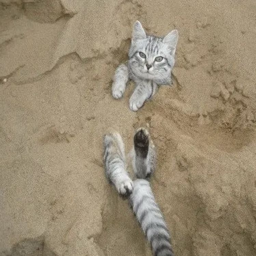

In [62]:
input_image.resize((256, 256))

In [63]:
categories = [s.strip() for s in requests.get(
    'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt').text.split('\n')]

top_prob, top_catid = torch.topk(probabilities, 3)
for i in range(top_prob.size(0)):
    print(categories[top_catid[i]], top_prob[i].item())

Egyptian cat 0.9107740521430969
tabby 0.03550940379500389
tiger cat 0.035491324961185455


## Интерпретируемость моделей

In [67]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def batch_predict(input_images):
    input_tensor = torch.tensor(
        [preprocess(input_image).numpy() for input_image in input_images])
    
    input_batch = input_tensor
    input_batch = input_batch.to(device)

    output = model(input_batch)
    probs = torch.nn.functional.softmax(output, dim=-1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(input_image), 
                                         batch_predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 5)

ax = np.empty([5], dtype=object)
for i in range(5):
      ax[i] = fig.add_subplot(gs[i])

for i in range(5):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    ax[i].imshow(img_boundry2)
    
    ax[i].set_title(categories[explanation.top_labels[i]])

plt.show()